# Data Story : Exploratory Data Analysis for Amazon Reviews dataset

## Capstone-1 by Dr. Uma Gajendragadkar

In [1]:
import os
import pandas as pd
import math
import gzip
import numpy as np
import scipy.stats as stats
from scipy.sparse import csc_matrix, csr_matrix
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from pyspark.mllib.recommendation import ALS, MatrixFactorizationModel, Rating
import seaborn as sns; sns.set(style="white", color_codes=True)
import warnings 

%matplotlib inline
warnings.filterwarnings("ignore")

In [101]:
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

video_data = getDF('reviews_Amazon_Instant_Video_5.json.gz')
automotive_data = getDF('reviews_Automotive_5.json.gz')
musical_data = getDF('reviews_Musical_Instruments_5.json.gz')
office_data = getDF('reviews_Office_Products_5.json.gz')
patio_data = getDF('reviews_Patio_Lawn_and_Garden_5.json.gz')

df = getDF('reviews_Patio_Lawn_and_Garden_5.json.gz')
patio_meta = getDF('meta_Patio_Lawn_and_Garden.json.gz')

video_meta = getDF('meta_Amazon_Instant_Video.json.gz')
automotive_meta = getDF('meta_Automotive.json.gz')
musical_meta = getDF('meta_Musical_Instruments.json.gz')
office_meta = getDF('meta_Office_Products.json.gz')

In [102]:
patio_meta.head()

,asin,description,title,imUrl,related,salesRank,categories,price,brand
0,0981850006,Steven Raichlen's Best of Barbecue Primal Gril...,"Primal Grill with Steven Raichlen, Volume One",http://ecx.images-amazon.com/images/I/51cNn5Dl...,"{'also_viewed': ['0761149430', '0761120149', '...",{'Movies & TV': 231134},"[[Patio, Lawn & Garden, Grills & Outdoor Cooki...",NaN,NaN
1,144072007X,The Tesoro Sand Shark metal combines time-prov...,Sand Shark Margare Maron Audio CD,http://ecx.images-amazon.com/images/I/31B9X0S6...,"{'also_viewed': ['B008WC0X0A', 'B000CPMOVG', '...","{'Patio, Lawn & Garden': 188289}","[[Patio, Lawn & Garden, Lawn Mowers & Outdoor ...",577.15,Tesoro
2,1554701503,This definitive guide to incorporating planks ...,Napoleon's Everyday Plank Grilling,http://ecx.images-amazon.com/images/I/51cTWw9d...,"{'also_bought': ['B0036Y9CH4', '1554702615', '...","{'Patio, Lawn & Garden': 196610}","[[Patio, Lawn & Garden, Grills & Outdoor Cooki...",26.39,Napoleon
3,1579822932,This is a Bad Kitty backpack pull clip.,Bad Kitty Backpack Pull,http://ecx.images-amazon.com/images/I/41nR62o%...,"{'also_bought': ['1596438444', '1596436700', '...",{'Toys & Games': 183251},"[[Patio, Lawn & Garden, Picnic Baskets & Acces...",3.65,Bad Kitty
4,1754164498,Every spa needs to be shocked to eliminate und...,5 pound SpaGuard Enhanced Spa Shock,http://ecx.images-amazon.com/images/I/21cOwSPt...,"{'also_bought': ['B00AJZO9MQ', 'B006MHSEVW', '...","{'Patio, Lawn & Garden': 80211}","[[Patio, Lawn & Garden, Pools, Hot Tubs & Supp...",29.99,SpaGuard


In [103]:
patio_data['unixReviewTime'] = pd.to_datetime(patio_data['unixReviewTime'],unit='s') #changing time format
#df.rename(columns={'unixReviewTime': 'ReviewTime', 'asin': 'product'}, inplace=True)
#df = df.drop('reviewTime',1)
patio_data.head(5)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A1JZFGZEZVWQPY,B00002N674,"Carter H ""1amazonreviewer@gmail . com""","[4, 4]",Good USA company that stands behind their prod...,4.0,Great Hoses,2011-06-21,"06 21, 2011"
1,A32JCI4AK2JTTG,B00002N674,"Darryl Bennett ""Fuzzy342""","[0, 0]",This is a high quality 8 ply hose. I have had ...,5.0,Gilmour 10-58050 8-ply Flexogen Hose 5/8-Inch ...,2014-06-09,"06 9, 2014"
2,A3N0P5AAMP6XD2,B00002N674,H B,"[2, 3]",It's probably one of the best hoses I've ever ...,4.0,Very satisfied!,2012-05-05,"05 5, 2012"
3,A2QK7UNJ857YG,B00002N674,Jason,"[0, 0]",I probably should have bought something a bit ...,5.0,Very high quality,2013-07-15,"07 15, 2013"
4,AS0CYBAN6EM06,B00002N674,jimmy,"[1, 1]",I bought three of these 5/8-inch Flexogen hose...,5.0,Good Hoses,2013-08-05,"08 5, 2013"


In [104]:
# merging two dataframes to create new subset of required data
finaldf = pd.merge(patio_data, patio_meta[['asin','title', 'categories', 'price']], on='asin', how='left')


In [107]:
#Data cleaning - dropping the rows with NAN 
finaldf = finaldf.dropna(how = 'any')
video_data = video_data.dropna(how= 'any')
automotive_data = automotive_data.dropna(how= 'any')
musical_data = musical_data.dropna(how= 'any')
office_data = office_data.dropna(how= 'any')


In [106]:
finaldf.shape

(12732, 12)

In [8]:
finaldf.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,title,categories,price
0,A1JZFGZEZVWQPY,B00002N674,"Carter H ""1amazonreviewer@gmail . com""","[4, 4]",Good USA company that stands behind their prod...,4.0,Great Hoses,2011-06-21,"06 21, 2011",Gilmour 10-58050 8-ply Flexogen Hose 5/8-Inch ...,"[[Patio, Lawn & Garden, Gardening & Lawn Care,...",29.53
1,A32JCI4AK2JTTG,B00002N674,"Darryl Bennett ""Fuzzy342""","[0, 0]",This is a high quality 8 ply hose. I have had ...,5.0,Gilmour 10-58050 8-ply Flexogen Hose 5/8-Inch ...,2014-06-09,"06 9, 2014",Gilmour 10-58050 8-ply Flexogen Hose 5/8-Inch ...,"[[Patio, Lawn & Garden, Gardening & Lawn Care,...",29.53
2,A3N0P5AAMP6XD2,B00002N674,H B,"[2, 3]",It's probably one of the best hoses I've ever ...,4.0,Very satisfied!,2012-05-05,"05 5, 2012",Gilmour 10-58050 8-ply Flexogen Hose 5/8-Inch ...,"[[Patio, Lawn & Garden, Gardening & Lawn Care,...",29.53
3,A2QK7UNJ857YG,B00002N674,Jason,"[0, 0]",I probably should have bought something a bit ...,5.0,Very high quality,2013-07-15,"07 15, 2013",Gilmour 10-58050 8-ply Flexogen Hose 5/8-Inch ...,"[[Patio, Lawn & Garden, Gardening & Lawn Care,...",29.53
4,AS0CYBAN6EM06,B00002N674,jimmy,"[1, 1]",I bought three of these 5/8-inch Flexogen hose...,5.0,Good Hoses,2013-08-05,"08 5, 2013",Gilmour 10-58050 8-ply Flexogen Hose 5/8-Inch ...,"[[Patio, Lawn & Garden, Gardening & Lawn Care,...",29.53


In [9]:

finaldf.rename(columns={'asin': 'product'}, inplace=True)
finaldf = finaldf.drop('unixReviewTime',1)

In [10]:
number_of_unique_products = len(finaldf['product'].unique())
number_of_unique_users = len(finaldf['reviewerID'].unique())
number_of_ratings = len(finaldf)
print ("Number of unique products =", number_of_unique_products)
print ("Number of unique users =", number_of_unique_users)
print ("Number of ratings =", number_of_ratings)

Number of unique products = 919
Number of unique users = 1685
Number of ratings = 12732


In [11]:
finaldf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12732 entries, 0 to 13271
Data columns (total 11 columns):
reviewerID      12732 non-null object
product         12732 non-null object
reviewerName    12732 non-null object
helpful         12732 non-null object
reviewText      12732 non-null object
overall         12732 non-null float64
summary         12732 non-null object
reviewTime      12732 non-null object
title           12732 non-null object
categories      12732 non-null object
price           12732 non-null float64
dtypes: float64(2), object(9)
memory usage: 1.2+ MB


In [12]:
finaldf = finaldf.drop(['reviewText','reviewerName','summary'],1)

In [13]:
finaldf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12732 entries, 0 to 13271
Data columns (total 8 columns):
reviewerID    12732 non-null object
product       12732 non-null object
helpful       12732 non-null object
overall       12732 non-null float64
reviewTime    12732 non-null object
title         12732 non-null object
categories    12732 non-null object
price         12732 non-null float64
dtypes: float64(2), object(6)
memory usage: 895.2+ KB


In [14]:
dftemp = pd.DataFrame(finaldf.groupby(['overall']).count()['product'].reset_index())

In [15]:
dftemp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 2 columns):
overall    5 non-null float64
product    5 non-null int64
dtypes: float64(1), int64(1)
memory usage: 160.0 bytes


In [16]:
dftemp.head()

,overall,product
0,1.0,495
1,2.0,639
2,3.0,1597
3,4.0,3255
4,5.0,6746


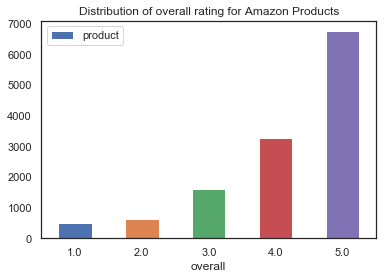

In [17]:
dftemp.plot.bar(x='overall', y='product', rot=0, title= 'Distribution of overall rating for Amazon Products')

In [18]:
dftemp = (finaldf.groupby(['overall']).count()['product'])

In [19]:
finaldf.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 12732 entries, 0 to 13271
Data columns (total 8 columns):
reviewerID    12732 non-null object
product       12732 non-null object
helpful       12732 non-null object
overall       12732 non-null float64
reviewTime    12732 non-null object
title         12732 non-null object
categories    12732 non-null object
price         12732 non-null float64
dtypes: float64(2), object(6)
memory usage: 895.2+ KB


In [20]:
import datetime as dt
finaldf['year']=pd.to_datetime(finaldf['reviewTime'], format='%m %d, %Y').dt.year

In [21]:
df_by_year = finaldf.groupby(['year'])


In [22]:
list(df_by_year)[10]

(2010,            reviewerID     product    helpful  overall   reviewTime  \
 73      AWC8CTW8N2XVE  B00004R9TL     [0, 0]      4.0  06 17, 2010   
 131    A14LG64GIVZIGS  B00004R9VV     [0, 0]      5.0  07 22, 2010   
 142    A27HB4L3I1WJUR  B00004R9YQ     [3, 4]      5.0  04 20, 2010   
 144    A2LOCNLCDMUKS0  B00004R9YQ     [7, 8]      5.0  03 27, 2010   
 150     AV97FVTK1KFXI  B00004RA0O   [14, 17]      3.0  05 19, 2010   
 152     AQ6AGWKWMTY8H  B00004RA0O   [13, 14]      5.0   06 2, 2010   
 160    A1HI4VM5Q4LUET  B00004RA3E     [1, 1]      2.0  05 27, 2010   
 174     ALHKJO0ZB0WXV  B00004RA3E     [0, 0]      4.0  06 20, 2010   
 200    A2I2KPNJDQ9SL0  B00004RA4G     [0, 0]      4.0   03 2, 2010   
 215    A35WNE2D0MPH4L  B00004RA8P     [2, 2]      3.0  08 22, 2010   
 221    A120ULF73SUTI9  B00004RA8P     [1, 1]      5.0  06 28, 2010   
 224     AWPODHOB4GFWL  B00004RA8P     [2, 2]      5.0  05 11, 2010   
 265    A2T99E90CFQA7Q  B00004RALL     [7, 7]      4.0  05 21, 2010   


In [23]:
df_p = df_by_year.mean()

In [24]:
df_p.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15 entries, 2000 to 2014
Data columns (total 2 columns):
overall    15 non-null float64
price      15 non-null float64
dtypes: float64(2)
memory usage: 360.0 bytes


In [25]:
df_p = df_p.reset_index()

In [26]:
df_p.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 3 columns):
year       15 non-null int64
overall    15 non-null float64
price      15 non-null float64
dtypes: float64(2), int64(1)
memory usage: 440.0 bytes


Text(0, 0.5, 'Average Rating of Products')

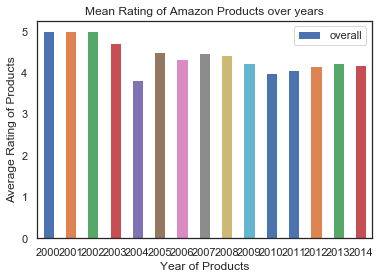

In [27]:
ax = df_p.plot.bar(x='year', y= 'overall', rot=0, title='Mean Rating of Amazon Products over years')
ax.set_xlabel('Year of Products')
ax.set_ylabel('Average Rating of Products')

In [28]:
# Get median values by year and print first 5 rows
df_med_by_year = df_by_year.median()
df_med_by_year.head()

,overall,price
year,,
2000,5.0,49.990
2001,5.0,13.605
2002,5.0,14.990
2003,5.0,49.640
2004,5.0,142.495


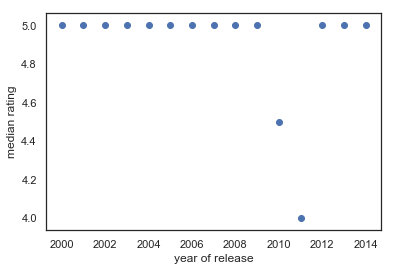

In [29]:
df_rat_by_year = df_med_by_year['overall']
plt.scatter(df_rat_by_year.index, df_rat_by_year)
plt.xlabel('year of release')
plt.ylabel('median rating');

In [41]:
#Trend on ratings given by Year 
# Plot  a graph of year vs. No.of Ratings of products
df2 = pd.DataFrame(finaldf.groupby('year').agg('sum')['overall'])
df2 = df2.reset_index()
df2.info()
df2.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 2 columns):
year       15 non-null int64
overall    15 non-null float64
dtypes: float64(1), int64(1)
memory usage: 320.0 bytes


,year,overall
0,2000,15.0
1,2001,10.0
2,2002,20.0
3,2003,33.0
4,2004,23.0


Text(0.5, 1.0, 'Trend on Ratings by Year')

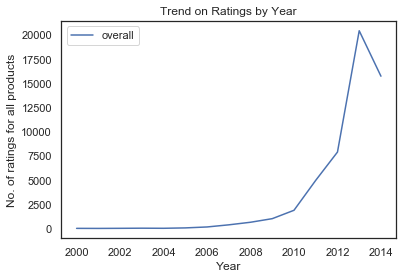

In [49]:
ax = df2.plot.line(x='year', y ='overall')
ax.set_xlabel('Year')
ax.set_ylabel('No. of ratings for all products')
ax.set_title('Trend on Ratings by Year')

In [60]:
finaldf.head()

,reviewerID,product,helpful,overall,reviewTime,title,categories,price,year
0,A1JZFGZEZVWQPY,B00002N674,"[4, 4]",4.0,"06 21, 2011",Gilmour 10-58050 8-ply Flexogen Hose 5/8-Inch ...,"[[Patio, Lawn & Garden, Gardening & Lawn Care,...",29.53,2011
1,A32JCI4AK2JTTG,B00002N674,"[0, 0]",5.0,"06 9, 2014",Gilmour 10-58050 8-ply Flexogen Hose 5/8-Inch ...,"[[Patio, Lawn & Garden, Gardening & Lawn Care,...",29.53,2014
2,A3N0P5AAMP6XD2,B00002N674,"[2, 3]",4.0,"05 5, 2012",Gilmour 10-58050 8-ply Flexogen Hose 5/8-Inch ...,"[[Patio, Lawn & Garden, Gardening & Lawn Care,...",29.53,2012
3,A2QK7UNJ857YG,B00002N674,"[0, 0]",5.0,"07 15, 2013",Gilmour 10-58050 8-ply Flexogen Hose 5/8-Inch ...,"[[Patio, Lawn & Garden, Gardening & Lawn Care,...",29.53,2013
4,AS0CYBAN6EM06,B00002N674,"[1, 1]",5.0,"08 5, 2013",Gilmour 10-58050 8-ply Flexogen Hose 5/8-Inch ...,"[[Patio, Lawn & Garden, Gardening & Lawn Care,...",29.53,2013


In [69]:
# Trend - Rating breakdown for products bt year
df3 = pd.DataFrame(finaldf.groupby(['overall']).count()['product'])
df3 = df3.reset_index()
df3.info()
df3.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 2 columns):
overall    5 non-null float64
product    5 non-null int64
dtypes: float64(1), int64(1)
memory usage: 160.0 bytes


,overall,product
0,1.0,495
1,2.0,639
2,3.0,1597
3,4.0,3255
4,5.0,6746


Text(0.5, 1.0, 'Distribution of overall ratings on Amazon Products')

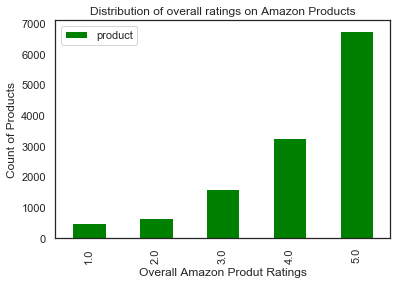

In [70]:
ax1 = df3.plot.bar(x='overall', y ='product', color='green')
ax1.set_xlabel('Overall Amazon Produt Ratings')
ax1.set_ylabel('Count of Products')
ax1.set_title('Distribution of overall ratings on Amazon Products')

In [72]:
# Plot for - Breakdown of Ratings by product Category
data = finaldf
data.categories.apply(pd.Series) \
    .merge(data, right_index = True, left_index = True) \
    .drop(["categories"], axis = 1) \
    .melt(id_vars = ['reviewerID', 'product', 'helpful','overall', 'reviewTime', 'title', 'price', 'year'], value_name = "category") \
    .drop("variable", axis = 1) \
    .dropna()

,reviewerID,product,helpful,overall,reviewTime,title,price,year,category
0,A1JZFGZEZVWQPY,B00002N674,"[4, 4]",4.0,"06 21, 2011",Gilmour 10-58050 8-ply Flexogen Hose 5/8-Inch ...,29.53,2011,"[Patio, Lawn & Garden, Gardening & Lawn Care, ..."
1,A32JCI4AK2JTTG,B00002N674,"[0, 0]",5.0,"06 9, 2014",Gilmour 10-58050 8-ply Flexogen Hose 5/8-Inch ...,29.53,2014,"[Patio, Lawn & Garden, Gardening & Lawn Care, ..."
2,A3N0P5AAMP6XD2,B00002N674,"[2, 3]",4.0,"05 5, 2012",Gilmour 10-58050 8-ply Flexogen Hose 5/8-Inch ...,29.53,2012,"[Patio, Lawn & Garden, Gardening & Lawn Care, ..."
3,A2QK7UNJ857YG,B00002N674,"[0, 0]",5.0,"07 15, 2013",Gilmour 10-58050 8-ply Flexogen Hose 5/8-Inch ...,29.53,2013,"[Patio, Lawn & Garden, Gardening & Lawn Care, ..."
4,AS0CYBAN6EM06,B00002N674,"[1, 1]",5.0,"08 5, 2013",Gilmour 10-58050 8-ply Flexogen Hose 5/8-Inch ...,29.53,2013,"[Patio, Lawn & Garden, Gardening & Lawn Care, ..."
5,A2UO040HWOP0C2,B00002N674,"[0, 0]",5.0,"10 18, 2012",Gilmour 10-58050 8-ply Flexogen Hose 5/8-Inch ...,29.53,2012,"[Patio, Lawn & Garden, Gardening & Lawn Care, ..."
6,A1VGXHHR08G044,B00002N67P,"[1, 1]",5.0,"08 24, 2011",Gilmour 10-34100 10 Series 3/4-Inch-by-100-Foo...,90.83,2011,"[Patio, Lawn & Garden, Gardening & Lawn Care, ..."
7,A1U6RLUA8D5DSX,B00002N67P,"[0, 0]",5.0,"03 31, 2012",Gilmour 10-34100 10 Series 3/4-Inch-by-100-Foo...,90.83,2012,"[Patio, Lawn & Garden, Gardening & Lawn Care, ..."
8,A2JSYW3B4KPD7I,B00002N67P,"[0, 0]",5.0,"01 7, 2014",Gilmour 10-34100 10 Series 3/4-Inch-by-100-Foo...,90.83,2014,"[Patio, Lawn & Garden, Gardening & Lawn Care, ..."
9,A126CN6N93XLZU,B00002N67P,"[0, 0]",4.0,"12 13, 2013",Gilmour 10-34100 10 Series 3/4-Inch-by-100-Foo...,90.83,2013,"[Patio, Lawn & Garden, Gardening & Lawn Care, ..."


In [73]:
finaldf.head()

,reviewerID,product,helpful,overall,reviewTime,title,categories,price,year
0,A1JZFGZEZVWQPY,B00002N674,"[4, 4]",4.0,"06 21, 2011",Gilmour 10-58050 8-ply Flexogen Hose 5/8-Inch ...,"[[Patio, Lawn & Garden, Gardening & Lawn Care,...",29.53,2011
1,A32JCI4AK2JTTG,B00002N674,"[0, 0]",5.0,"06 9, 2014",Gilmour 10-58050 8-ply Flexogen Hose 5/8-Inch ...,"[[Patio, Lawn & Garden, Gardening & Lawn Care,...",29.53,2014
2,A3N0P5AAMP6XD2,B00002N674,"[2, 3]",4.0,"05 5, 2012",Gilmour 10-58050 8-ply Flexogen Hose 5/8-Inch ...,"[[Patio, Lawn & Garden, Gardening & Lawn Care,...",29.53,2012
3,A2QK7UNJ857YG,B00002N674,"[0, 0]",5.0,"07 15, 2013",Gilmour 10-58050 8-ply Flexogen Hose 5/8-Inch ...,"[[Patio, Lawn & Garden, Gardening & Lawn Care,...",29.53,2013
4,AS0CYBAN6EM06,B00002N674,"[1, 1]",5.0,"08 5, 2013",Gilmour 10-58050 8-ply Flexogen Hose 5/8-Inch ...,"[[Patio, Lawn & Garden, Gardening & Lawn Care,...",29.53,2013


In [97]:
#Group by User and count number of ratings given and plot
df4 = pd.DataFrame(finaldf.groupby('reviewerID').count()['overall'].reset_index())
df4.head()

,reviewerID,overall
0,A100WO06OQR8BQ,63
1,A1047EDJ84IMAS,7
2,A106ZCP7RSXMRU,5
3,A10BGNHGWPN7ZE,13
4,A10H24TDLK2VDP,8


In [100]:
# Number of ratings given by user max = 63, min = 1 and mean = 7.55
print("Total number of users in Garden and Patio dataset:", df4['reviewerID'].count())
print("Maximum number of ratings given by user:", df4['overall'].max())
print("Average number of ratings by users:", df4['overall'].mean())
print("Minimum number of ratings by user:", df4['overall'].min())

Total number of users in Garden and Patio dataset: 1685
Maximum number of ratings given by user: 63
Average number of ratings by users: 7.5560830860534125
Minimum number of ratings by user: 1


Text(0.5, 1.0, 'Distribution of Ratings per User')

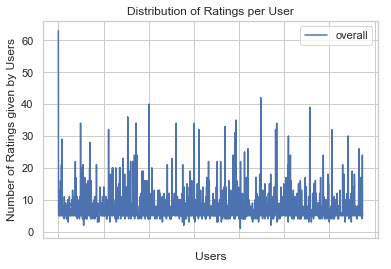

In [92]:
bx = df4.plot(x= 'reviewerID', y = 'overall')
bx.set_xlabel("Users")
bx.set_ylabel("Number of Ratings given by Users")
bx.set_title("Distribution of Ratings per User")

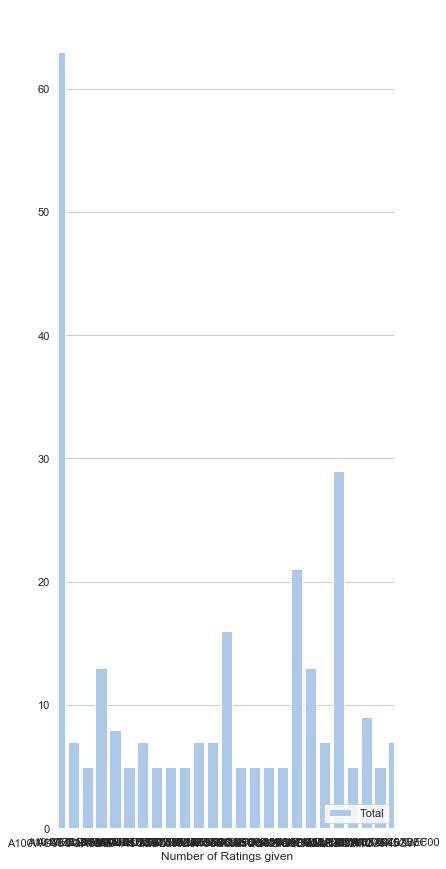

In [90]:
#Same plot of Number of Ratings given by each user in seaborn
sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 15))

# Load the dataset
#rating = sns.load_dataset(df4).sort_values("overall", ascending=False)

# Plot the total ratings for each user
sns.set_color_codes("pastel")
sns.barplot(x="reviewerID", y="overall", data=df4,
            label="Total", color="b")



# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 24), ylabel="",
       xlabel="Number of Ratings given")
sns.despine(left=True, bottom=True)

In [171]:
df_video = video_data.groupby('overall').count()['asin'].reset_index()

In [172]:
df_video.head()


,overall,asin
0,1.0,1695
1,2.0,1873
2,3.0,4158
3,4.0,8383
4,5.0,20688


In [173]:
df_video = df_video.set_index('overall').T

df_video.head()
#df_video.plot(kind='bar', stacked =True)

overall,1.0,2.0,3.0,4.0,5.0
asin,1695,1873,4158,8383,20688


<class 'pandas.core.frame.DataFrame'>
Index: 1 entries, asin to asin
Data columns (total 5 columns):
1.0    1 non-null int64
2.0    1 non-null int64
3.0    1 non-null int64
4.0    1 non-null int64
5.0    1 non-null int64
dtypes: int64(5)
memory usage: 48.0+ bytes


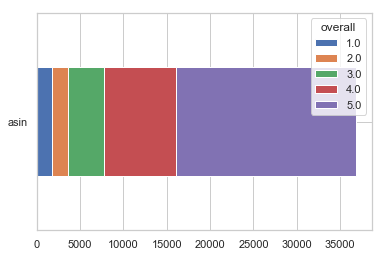

In [177]:
df_video.info()
df_video.plot(kind='barh', stacked= True)

In [183]:
# finding number of products with each rating category [1,2,3,4,5]
df_video = video_data.groupby('overall').count()['asin'].reset_index()
df_musical = musical_data.groupby('overall').count()['asin'].reset_index()
df_office = office_data.groupby('overall').count()['asin'].reset_index()
df_automotive = automotive_data.groupby('overall').count()['asin'].reset_index()
df_patio = patio_data.groupby('overall').count()['asin'].reset_index()

In [200]:
#Plot of number of products with each rating by productyyy category

x=df_video['overall']  #since the date are the same in both tables I only have 1 x
y1=df_video['asin']
y2=df_office['asin']
y3=df_musical['asin']
y4 = df_patio['asin']
y5 = df_automotive['asin']
df_new = pd.DataFrame()
df_new['overall'] = x
df_new['video'] = y1
df_new['office'] = y2
df_new['musical']= y3
df_new['patio'] = y4
df_new['automotive'] = y5
df_new.columns = ['Rating', 'Instant Video', 'Office', 'Musical Instruments', 'Patio Lawn & Garden', 'Automotive']
df_new.reset_index()
df_new.set_index('Rating')
df_new.head()

,Rating,Instant Video,Office,Musical Instruments,Patio Lawn & Garden,Automotive
0,1.0,1695,1126,216,519,536
1,2.0,1873,1716,249,673,597
2,3.0,4158,5030,771,1659,1413
3,4.0,8383,14893,2080,3384,3927
4,5.0,20688,30034,6918,7037,13787


<Figure size 432x288 with 0 Axes>

In [201]:
df_new = df_new.set_index('Rating').transpose()
df_new

Rating,1.0,2.0,3.0,4.0,5.0
Instant Video,1695,1873,4158,8383,20688
Office,1126,1716,5030,14893,30034
Musical Instruments,216,249,771,2080,6918
Patio Lawn & Garden,519,673,1659,3384,7037
Automotive,536,597,1413,3927,13787


<Figure size 1800x1800 with 0 Axes>

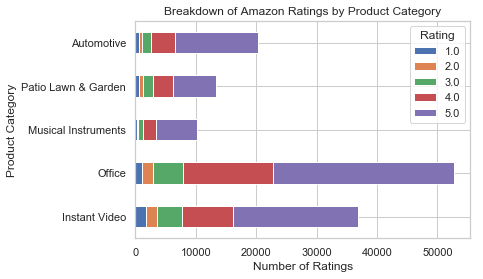

In [205]:
fig = plt.figure()

bx1 = df_new.plot( kind='barh', stacked=True)
    
bx1.set_title("Breakdown of Amazon Ratings by Product Category")
bx1.set_xlabel('Number of Ratings')
bx1.set_ylabel('Product Category')
plt.show()